# ML Experiment Tips!
- If your model is underfitting the training data, adding more training examples will not help. You need to use a more complex model or come up with better features.

- One way to improve an overfitting model is to feed it more training data until the validation error reaches the training error.

- Bias-Variance Tradeoff: Increasing a model’s complexity will typically increase its variance and reduce its bias. Conversely, reducing a model’s complexity increases its bias and reduces its variance. This is why it is called a trade-off

In [ ]:
!pip install Neural-Decoding

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import os
from numpy import loadtxt

# Binary Classification with Sonar Dataset: Baseline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# load the dataset
path = '/content/drive/My Drive/data/data_lda_20170828/1004'

data_list = [(3,1),(3,2),(4,1),(4,2),(4,3),(5,3)] 
data_list2 = [(1,4),(1,5),(1,6),(2,1),(2,2),(2,6),(3,1),(3,2),(4,1),(4,2),(4,3),(5,2),(5,3)] 
k = len(data_list2)

# list of dictionary : a form of day and inj
cellMouse = path.split('/')[-1]

# dirs = glob.glob(os.path.join(path, '1*'))
X_list = []
Y_list = []

# for each video folder
for day, inj in data_list2:
  datasetName = os.path.join(path, 'TRACES_'+ cellMouse +'_'+ str(day) +'_' + str(inj) +'.csv')
  labelName = os.path.join(path, 'BEHAVIOR_'+ cellMouse +'_'+ str(day) +'_' +str(inj)+'.csv')

  dataset = np.transpose(loadtxt(datasetName, delimiter=','))
  label = loadtxt(labelName, delimiter=',')[:,2]

  X_list.append(dataset)
  Y_list.append(label)

X = np.vstack(X_list)
y = np.vstack(Y_list)
y = y.reshape(-1)

scaler = StandardScaler() # expected dim=2
X = scaler.fit_transform(X) # normalize/standardize features

print(X.shape, y.shape)

(39000, 273) (39000,)


## Feature Preprecessing

(39000, 273)


## Non-Recurrent Decoders

In [ ]:
# X: (3000*# of videos, num_features) -> select bin_len -> (3000*# of videos/bin_len, bin_len, num_features) 
# -> select B_num -> (3000*# of videos/(bin_len*bin_num), bin_len * bin_num * num_features) 

# y: (3000*# of videos, 1) -> (3000*# of videos/(bin_len*bin_num), 600) -> leave the last output in aggregated B bins -> (3000*# of videos/(bin_len*bin_num), 1)

bin_len = 10 # = temporal resolution R 
bin_num = 1 # number of bins for a prediction B
num_features = 273 # number of features N

X = X.reshape(-1, bin_len*bin_num*num_features)
y = y.reshape(-1, bin_len*bin_num)
y = y[:,-1]
print(X.shape, y.shape)

(3900, 2730) (3900,)


## Random Forest

In [ ]:
n_estimators=
max_features=
max_depth=
min_samples_split=
min_samples_leaf=

In [ ]:
def build_RF(X_train, y_train, X_test):
  rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
  rnd_clf.fit(X_train, y_train)
  y_pred = rnd_clf.predict(X_test)

  return y_pred

In [ ]:
def build_SVM(X_train, y_train, X_test): # use the SVC class with a linear kernel.
  # scales the features 
  svm_clf = Pipeline([
          ("scaler", StandardScaler()),
          ("linear_svc", LinearSVC(C=1, loss="hinge")),
      ])
  svm_clf.fit(X_train, y_train)
  # Unlike Logistic Regression classifiers, SVM classifiers do not output probabilities for each class
  y_pred = svm_clf.predict(X_test)

  return y_pred

In [ ]:
# train using cross-validation
num_val_samples = len(X) // k
print(num_val_samples)

all_scores = []

for i in range(k):
    print('processing fold #', i+1)
    val_X = X[i * num_val_samples : (i + 1) * num_val_samples]
    val_y = y[i * num_val_samples : (i + 1) * num_val_samples]

    train_X = np.concatenate(                                     
        [X[:i * num_val_samples],
         X[(i + 1) * num_val_samples:]], axis=0)

    train_y = np.concatenate(
        [y[:i * num_val_samples],
         y[(i + 1) * num_val_samples:]], axis=0)
  
    y_pred = build_SVM(train_X, train_y, val_X)
    all_scores.append(accuracy_score(val_y, y_pred))

print(all_scores)
print("average accuracy: {} ".format(np.mean(all_scores)))

5
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4
processing fold # 5
processing fold # 6
processing fold # 7
processing fold # 8
processing fold # 9
processing fold # 10
processing fold # 11
processing fold # 12
processing fold # 13
[0.6, 0.8, 0.8, 0.8, 0.8, 0.8, 0.6, 0.6, 0.8, 0.8, 0.6, 1.0, 0.4]
average accuracy: 0.7230769230769231 


## DNN

In [ ]:
def build_dnn(bin_len, bin_num, num_features):
    model = keras.Sequential(
  [
   layers.Dense(40, input_shape=(bin_len*bin_num*num_features,)),
   layers.Dropout(0.2),
   layers.Dense(20, activation='relu'),
   layers.Dropout(0.2),
   layers.Dense(1, activation='sigmoid')
  ])
    opt = keras.optimizers.Adam(learning_rate=0.01) 
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

model = build_dnn(bin_len, bin_num, num_features)
model.summary()

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_101 (Dense)            (None, 40)                109240    
_________________________________________________________________
dropout_72 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_102 (Dense)            (None, 20)                820       
_________________________________________________________________
dropout_73 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_103 (Dense)            (None, 1)                 21        
Total params: 110,081
Trainable params: 110,081
Non-trainable params: 0
_________________________________________________________________


## Recurrent Decoders: LSTM/GRU

In [ ]:
# Recurrent Neural Decoders: LSTM/GRU
# 1. decide the temporal resolution, R
# T/R total data points

# 2. decide the time period to predict a given output (output data must be further preprocessed)
# a. every timestep in a bin (no preprocessing y required)
# b. last timestep in a bin
# c. last timestep in multiple bins

# X: (3000*# of videos, num_features) -> select bin_len -> (3000*# of videos/bin_len, bin_len, num_features) 
# -> select B_num -> (3000*# of videos/(bin_len*bin_num), bin_len*bin_num * num_features) 

# y: (3000*# of videos, 1) -> (3000*# of videos/(bin_len*bin_num), 600) -> leave the last output in aggregated B bins -> (3000*# of videos/(bin_len*bin_num), 1)

bin_len = 200 # = temporal resolution R (window)
bin_num = 3 # number of bins for a prediction B
num_features = 273 # number of features N

X = X.reshape(-1, bin_len*bin_num, num_features) 
y = y.reshape(-1, bin_len*bin_num, 1)
print(X.shape, y.shape)

(65, 600, 273) (65, 600, 1)


In [ ]:
def build_lstm(bin_len, bin_num, num_features):
    model = keras.Sequential(
  [
   layers.LSTM(units=100, input_shape=(bin_len*bin_num, num_features), return_sequences=True),
   layers.Dropout(0.2),
   layers.TimeDistributed(layers.Dense(1, activation='sigmoid'))
  ])
    opt = keras.optimizers.Adam(learning_rate=0.01) 
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

model = build_lstm(bin_len, bin_num, num_features)
model.summary()

Model: "sequential_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 600, 100)          149600    
_________________________________________________________________
dropout_101 (Dropout)        (None, 600, 100)          0         
_________________________________________________________________
time_distributed_15 (TimeDis (None, 600, 1)            101       
Total params: 149,701
Trainable params: 149,701
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# train using cross-validation
num_val_samples = len(X) // k
print(num_val_samples)

num_epochs = 5
batch_size = 20 # of batches = (# of examples / batch_size)

all_scores = []

for i in range(k):
    print('processing fold #', i+1)
    val_X = X[i * num_val_samples : (i + 1) * num_val_samples]
    val_y = y[i * num_val_samples : (i + 1) * num_val_samples]

    train_X = np.concatenate(                                     
        [X[:i * num_val_samples],
         X[(i + 1) * num_val_samples:]], axis=0)

    train_y = np.concatenate(
        [y[:i * num_val_samples],
         y[(i + 1) * num_val_samples:]], axis=0)
  
    model = build_lstm(bin_len, bin_num, num_features)                                 
    history = model.fit(train_X, train_y, epochs=num_epochs, batch_size=batch_size, validation_data=(val_X, val_y), verbose=1)
    val_loss, val_acc = model.evaluate(val_X, val_y, verbose=0)      
    all_scores.append(val_acc)

print(all_scores)
print("average accuracy: {} ".format(np.mean(all_scores)))

5
processing fold # 1
Epoch 1/5
3/3 [==============================] - 1s 170ms/step - loss: 0.7273 - accuracy: 0.5873 - val_loss: 0.7603 - val_accuracy: 0.5577
Epoch 2/5
3/3 [==============================] - 0s 50ms/step - loss: 0.5701 - accuracy: 0.7089 - val_loss: 0.7448 - val_accuracy: 0.5480
Epoch 3/5
3/3 [==============================] - 0s 45ms/step - loss: 0.5103 - accuracy: 0.7562 - val_loss: 0.7505 - val_accuracy: 0.5337
Epoch 4/5
3/3 [==============================] - 0s 30ms/step - loss: 0.4710 - accuracy: 0.7842 - val_loss: 0.7580 - val_accuracy: 0.5470
Epoch 5/5
3/3 [==============================] - 0s 27ms/step - loss: 0.4242 - accuracy: 0.8154 - val_loss: 0.7966 - val_accuracy: 0.5387
processing fold # 2
Epoch 1/5
3/3 [==============================] - 1s 169ms/step - loss: 0.7400 - accuracy: 0.5789 - val_loss: 0.6148 - val_accuracy: 0.6450
Epoch 2/5
3/3 [==============================] - 0s 42ms/step - loss: 0.5716 - accuracy: 0.7040 - val_loss: 0.6404 - val_accurac

### Visualize Train/Val Loss/Acc

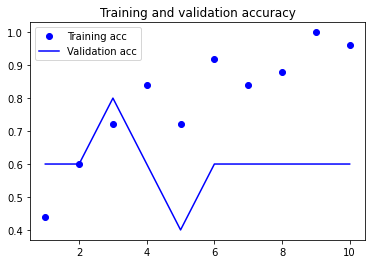

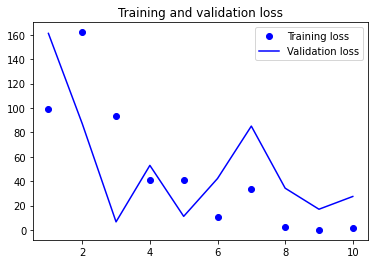

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Decision Trees

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

In [ ]:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

## Support Vector Machines


### Linear SVM Classification
If two classes can clearly be linearly separated easily with a straight line (decision boundary), we start with using LinearSVM.

However, if the decision boundaries come so close to the instances, then these models will probably not perform well on new instances.

Therefore, we aim to not only separate the two classes but also stays as far away from the closest training instances as possible (think SVM of fitting the widest possible street between the classification : large margin classification)

decision boundary is full determined by the instances located on the edge of the street and such instances are called **"SUPPORT VECTORS"**
```
- SVMs are sensitive to the feature scales, be sure to use StandardScaler for feature scaling
- If your SVM model is overfitting, try regularizing it by reducing C
```

### Soft vs. Hard margin classification
all instance must be off the street and on the right side, this is called hard margin. There are two main issues with it that it only works when the data is linearly separable and sensitive to outliars.

To avoid these issues, use a more flexible model called soft margin. The objective is to find a good balance between maximizing the margin and limiting the margin violations.



Instead of using the LinearSVC class, we could use the SVC class with a linear kernel. When creating the SVC model, we would write SVC(kernel="linear", C=1).

```
The LinearSVC class regularizes the bias term, so you should center the training set first by subtracting its mean. This is automatic if you scale the data using the StandardScaler. Also make sure you set the loss hyperparameter to "hinge", as it is not the default value. Finally, for better performance, you should set the dual hyperparameter to False, unless there are more features than training instances.
```


## Nonlinear SVM Classification

many datasets are not even close to being linearly separable.

One approach is to add more features (polynomial features) and in somes cases it results in linearly separable dataset.

Although it is simple to implement, it poses issues that at a low degree it cannot deal with complex dataset and with a high degree it creates a huge number of features, making the training too slow.

### kernel trick
makes it possible to get the same results as if you had added many polynomial features, even with very high-degree polynomials, without actually having to add them.

In [ ]:
# Polynomial Kernel
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

poly_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
    ])

poly_kernel_svm_clf.fit(X_train, y_train)
y_pred = poly_kernel_svm_predict(X_test)
print(accuracy_score(y_test, y_pred))

**With so many kernels to choose from, how can you decide which one to use?**
```
As a rule of thumb, you should always try the linear kernel first (remember that LinearSVC is much faster than SVC(kernel="linear")), especially if the training set is very large or if it has plenty of features. If the training set is not too large, you should also try the Gaussian RBF kernel; it works well in most cases. Use cross-validation and grid search for searching a few other kernels. You’d want to experiment like that especially if there are kernels specialized for your training set’s data structure.
```


For online learning, we could use the SGDClassifier class, with SGDClassifier(loss="hinge", alpha=1/(m*C)). This applies regular Stochastic Gradient Descent to train a linear SVM classifier. It does not converge as fast as the LinearSVC class, but it can be useful to handle online classification tasks or huge datasets that do not fit in memory (out-of-core training).

### Under the Hood
The linear SVM classifier model predicts the class of a new instance x by simply computing the decision function w⊺ x + b = w1 x1 + ⋯ + wn xn + b. If the result is positive, the predicted class ŷ is the positive class (1), and otherwise it is the negative class (0)


Consider the slope of the decision function: it is equal to the norm of the weight vector, ∥ w ∥. If we divide this slope by 2, the points where the decision function is equal to ±1 are going to be twice as far away from the decision boundary. 

```
dividing the slope by 2 will multiply the margin by 2. The smaller the weight vector w, the larger the margin.
```

Training a linear SVM classifier means finding the values of w and b that make this margin as wide as possible while avoiding margin violations (hard margin) or limiting them (soft margin).